## Optimal Controller

The purpose of this notebook is to try and get some upper bound on performance. So:

- Given a file with the known picked peaks
- Use a controller that only fragments things that are within a picked peak
- This will help us see how many of the picked peaks we can, realistically obtain

In [70]:
import os

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import xml.etree.ElementTree
import os,glob,sys
import numpy as np
import pandas as pd
import seaborn as sns

In [73]:
sys.path.append('/Users/simon/git/vimms')
sys.path.append('/Users/simon/git/pymzm')

sys.path.append('/home/simon/git/vimms')
sys.path.append('/home/simon/git/pymzm')

In [74]:
from vimms.PythonMzmine import *
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController,RoiController,SmartRoiController
from vimms.PythonMzmine import *

from vimms.Roi import make_roi, RoiToChemicalCreator
from vimms.BOMAS import *
from vimms.Common import *
from vimms.Environment import *
from pathlib import Path
from vimms.PlotsForPaper import get_frag_events

In [76]:
from vimms.DataGenerator import extract_hmdb_metabolite, get_data_source, get_spectral_feature_database

In [77]:
set_log_level_warning()

In [78]:
# base_dir = os.path.abspath('/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/Trained Models')
base_dir = os.path.abspath('/home/simon/git/vimms/experimental/simon_res/QCB')

ps_frag_QCB = load_obj(Path(base_dir, 'peak_sampler_mz_rt_int_beerqcb_fragmentation.p'))

In [79]:
QCB_MZML2CHEMS_DICT = {'min_ms1_intensity': 0,
                  'mz_tol': 5,
                  'mz_units':'ppm',
                  'min_length':1,
                  'min_intensity':0,
                  'start_rt':0,
                  'stop_rt':1560}

In [80]:
# TopN_QCB_dataset = load_obj('/Users/simon/OneDrive - University of Glasgow/CLDS Metabolomics Project/TopNvsTopNroi/QCB/SimulatorTests/TopN_QCB_dataset.mzml')
TopN_QCB_dataset = load_obj('/home/simon/git/vimms/experimental/simon_res/QCB/TopN_QCB_dataset.mzml')

In [81]:
min_rt = 0
max_rt = 26*60 # entire run
min_ms1_intensity = 5000
mz_tol = 10
rt_tol = 15
N = 10

# these are derived from real data (see bottom of notebook)
roi_time_dict = {1: 0.71,2:0.20}
topn_time_dict = {1: 0.60,2:0.20}


ionisation_mode = POSITIVE
isolation_width = 1

test_path = '/Users/simon/git/vimms/experimental/simon_res/'
test_path = '/home/simon/git/vimms/experimental/simon_res/'



In [82]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import OptimalTopNController

In [ ]:
boxes = load_picked_boxes(os.path.join(test_path,'QCB','qcb_pp.csv'))

In [ ]:
controller = OptimalTopNController(ionisation_mode, N, isolation_width,
                                   mz_tol, rt_tol, min_ms1_intensity,
                                   boxes)

In [33]:
mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCB_dataset,
                                        ps_frag_QCB,
                                        add_noise=True,
                                       scan_duration_dict=roi_time_dict)
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

# env.write_mzML(test_path, 'Optimal_roi_times.mzml')


controller = OptimalTopNController(ionisation_mode, N, isolation_width,
                                   mz_tol, rt_tol, min_ms1_intensity,
                                   boxes)
mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCB_dataset,
                                        ps_frag_QCB,
                                        add_noise=True,
                                       scan_duration_dict=topn_time_dict)
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

# env.write_mzML(test_path, 'Optimal_tn_times.mzml')

['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCB.mzML filtered Peak m/z', 'from_controller_TopN_QCB.mzML filtered Peak RT start', 'from_controller_TopN_QCB.mzML filtered Peak RT end', 'from_controller_TopN_QCB.mzML filtered Peak height', 'from_controller_TopN_QCB.mzML filtered Peak area', 'from_controller_TopN_QCB.mzML filtered Peak m/z min', 'from_controller_TopN_QCB.mzML filtered Peak m/z max', '']


(20.650s) ms_level=1 N=10 DEW=15:  99%|█████████▉| 9.940000000000001/10 [00:00<00:00, 21.21it/s]
(20.200s) ms_level=1 N=10 DEW=15:  96%|█████████▌| 9.599999999999998/10 [00:00<00:00, 18.07it/s] 


In [29]:
from mass_spec_utils.data_import.mzml import MZMLFile
from mass_spec_utils.data_import.mzmine import load_picked_boxes, map_boxes_to_scans
peak_csv_file = os.path.join(test_path,'QCB/qcb_pp.csv')
boxes = load_picked_boxes(peak_csv_file)
print(len(boxes))

['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCB.mzML filtered Peak m/z', 'from_controller_TopN_QCB.mzML filtered Peak RT start', 'from_controller_TopN_QCB.mzML filtered Peak RT end', 'from_controller_TopN_QCB.mzML filtered Peak height', 'from_controller_TopN_QCB.mzML filtered Peak area', 'from_controller_TopN_QCB.mzML filtered Peak m/z min', 'from_controller_TopN_QCB.mzML filtered Peak m/z max', '']
7306


In [30]:
roi_times_mz_file = MZMLFile(os.path.join(test_path,'Optimal_roi_times.mzml'))
topn_times_mz_file = MZMLFile(os.path.join(test_path,'Optimal_tn_times.mzml'))

def summarise(mz_file_object):
    n_scans = len(mz_file_object.scans)
    n_ms1_scans = len(list(filter(lambda x: x.ms_level == 1,mz_file_object.scans)))
    n_ms2_scans = len(list(filter(lambda x: x.ms_level == 2,mz_file_object.scans)))
    print("Total scans = {}, MS1 = {}, MS2 = {}".format(n_scans,n_ms1_scans,n_ms2_scans))
print("TopN:")
summarise(topn_times_mz_file)
print("ROI:")
summarise(roi_times_mz_file)


scans2boxes,roi_b2s = map_boxes_to_scans(roi_times_mz_file,boxes,half_isolation_window = 0)
print("ROI timings: ",len(roi_b2s))
scans2boxes,topn_b2s = map_boxes_to_scans(topn_times_mz_file,boxes,half_isolation_window = 0)
print("TopN timings: ",len(topn_b2s))



Loaded 3744 scans
Loaded 4071 scans
TopN:
Total scans = 4071, MS1 = 1826, MS2 = 2245
ROI:
Total scans = 3744, MS1 = 1563, MS2 = 2181
ROI timings:  2154
TopN timings:  2209


In [142]:
smart_mzml_file = MZMLFile(os.path.join(test_path,'SMART3_3_0.1.mzml'))
_,smart_b2s = map_boxes_to_scans(smart_mzml_file,boxes,half_isolation_window=0)
print(len(smart_b2s))


Loaded 4482 scans
1043


1157
276.1446838378906 [275.73612515200017, 345.6913529110002]


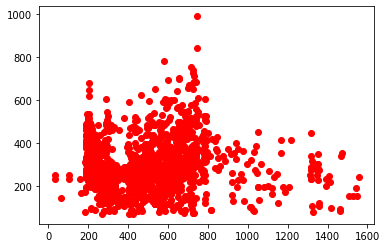

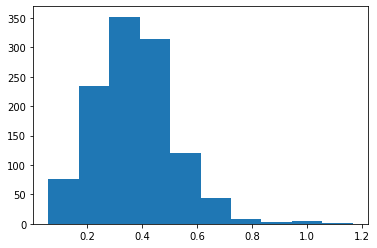

In [157]:
import pylab as plt
%matplotlib inline
# which ones are we not getting
optimal_boxes = set(roi_b2s.keys())
smart_boxes = set(smart_b2s.keys())
missing = optimal_boxes - smart_boxes
mz = [z.mz for z in missing]
rt = [60*z.rt_range[0] for z in missing]
plt.plot(rt,mz,'ro')
print(len(missing))
# missing_intesnity = [max(z.intensity_list) for z in missing]
plt.figure()
# plt.hist(missing_intensity)
length = [z.rt_range[1] - z.rt_range[0] for z in missing]
plt.hist(length)
a = sorted(list(missing),key = lambda x: x.rt_range[1]-x.rt_range[0],reverse = True)
print(a[0].mz,[p*60.0 for p in a[0].rt_range])

# Repeat with QCA

In [18]:
# mzml_QCA_TopN = '/Users/simon/University of Glasgow/Vinny Davies - CLDS Metabolomics Project/TopNvsTopNroi/QCA/from_controller_TopN_QCA.mzML'
# mzml_QCA_TopN = '/home/simon/git/vimms/experimental/simon_res/QCA/from_controller_TopN_QCA.mzml'
# TopN_QCA_dataset = mzml2chems(mzml_QCA_TopN, ps_frag_QCB, QCB_MZML2CHEMS_DICT, n_peaks=None)

In [ ]:
# save_obj(TopN_QCA_dataset, '/Users/simon/OneDrive - University of Glasgow/CLDS Metabolomics Project/TopNvsTopNroi/QCA/SimulatorTests/TopN_QCA_dataset.mzml')



In [19]:
# TopN_QCA_dataset = load_obj('/Users/simon/OneDrive - University of Glasgow/CLDS Metabolomics Project/TopNvsTopNroi/QCA/SimulatorTests/TopN_QCA_dataset.mzml')
TopN_QCA_dataset = load_obj('/home/simon/git/vimms/experimental/simon_res/QCA/TopN_QCA_dataset.mzml')

In [25]:
from vimms.Controller import OptimalTopNController
controller = OptimalTopNController(ionisation_mode, N, isolation_width,
                                   mz_tol, rt_tol, min_ms1_intensity,
                                   os.path.join(test_path,'QCA','qca_pp.csv'))


mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCA_dataset,
                                        ps_frag_QCB,
                                        add_noise=True,
                                       scan_duration_dict=roi_time_dict)
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

env.write_mzML(test_path, 'Optimal_roi_times_qca.mzml')

['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCA.mzML filtered Peak m/z', 'from_controller_TopN_QCA.mzML filtered Peak RT start', 'from_controller_TopN_QCA.mzML filtered Peak RT end', 'from_controller_TopN_QCA.mzML filtered Peak height', 'from_controller_TopN_QCA.mzML filtered Peak area', 'from_controller_TopN_QCA.mzML filtered Peak m/z min', 'from_controller_TopN_QCA.mzML filtered Peak m/z max', '']
Loaded 6161 boxes


(1560.380s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.6700000000785/1560 [01:30<00:00, 17.24it/s]


In [26]:
controller = OptimalTopNController(ionisation_mode, N, isolation_width,
                                   mz_tol, rt_tol, min_ms1_intensity,
                                   os.path.join(test_path,'QCA','qca_pp.csv'))
mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCA_dataset,
                                        ps_frag_QCB,
                                        add_noise=True,
                                       scan_duration_dict=topn_time_dict)
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
env.run()

env.write_mzML(test_path, 'Optimal_tn_times_qca.mzml')

['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCA.mzML filtered Peak m/z', 'from_controller_TopN_QCA.mzML filtered Peak RT start', 'from_controller_TopN_QCA.mzML filtered Peak RT end', 'from_controller_TopN_QCA.mzML filtered Peak height', 'from_controller_TopN_QCA.mzML filtered Peak area', 'from_controller_TopN_QCA.mzML filtered Peak m/z min', 'from_controller_TopN_QCA.mzML filtered Peak m/z max', '']
Loaded 6161 boxes


(1560.200s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.5999999999774/1560 [01:37<00:00, 15.98it/s]


In [27]:
from mass_spec_utils.data_import.mzml import MZMLFile
from mass_spec_utils.data_import.mzmine import load_picked_boxes, map_boxes_to_scans
peak_csv_file = os.path.join(test_path,'QCA','qca_pp.csv')
boxes = load_picked_boxes(peak_csv_file)

roi_times_mz_file = MZMLFile(os.path.join(test_path,'Optimal_roi_times_qca.mzml'))
topn_times_mz_file = MZMLFile(os.path.join(test_path,'Optimal_tn_times_qca.mzml'))

def summarise(mz_file_object):
    n_scans = len(mz_file_object.scans)
    n_ms1_scans = len(list(filter(lambda x: x.ms_level == 1,mz_file_object.scans)))
    n_ms2_scans = len(list(filter(lambda x: x.ms_level == 2,mz_file_object.scans)))
    print("Total scans = {}, MS1 = {}, MS2 = {}".format(n_scans,n_ms1_scans,n_ms2_scans))
print("TopN:")
summarise(topn_times_mz_file)
print("ROI:")
summarise(roi_times_mz_file)


scans2boxes,boxes2scans = map_boxes_to_scans(roi_times_mz_file,boxes,half_isolation_window = 0)
print("ROI timings: ",len(boxes2scans))
scans2boxes,boxes2scans = map_boxes_to_scans(topn_times_mz_file,boxes,half_isolation_window = 0)
print("TopN timings: ",len(boxes2scans))




['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCA.mzML filtered Peak m/z', 'from_controller_TopN_QCA.mzML filtered Peak RT start', 'from_controller_TopN_QCA.mzML filtered Peak RT end', 'from_controller_TopN_QCA.mzML filtered Peak height', 'from_controller_TopN_QCA.mzML filtered Peak area', 'from_controller_TopN_QCA.mzML filtered Peak m/z min', 'from_controller_TopN_QCA.mzML filtered Peak m/z max', '']
Loaded 3608 scans
Loaded 3921 scans
TopN:
Total scans = 3921, MS1 = 1896, MS2 = 2025
ROI:
Total scans = 3608, MS1 = 1617, MS2 = 1991
ROI timings:  1947
TopN timings:  1987


## Put it in a loop!

In [44]:
output_folder = os.path.join(test_path,'loop_controller')
boxes = load_picked_boxes(os.path.join(test_path,'QCB','qcb_pp_wide.csv'))
from vimms.Controller import OptimalTopNController
for i in range(10):
    print("Iteration {}, {} peaks remaining".format(i,len(boxes)))
    controller = OptimalTopNController(ionisation_mode, N, isolation_width,
                                       mz_tol, rt_tol, min_ms1_intensity,
                                       boxes)
    mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCB_dataset,
                                            ps_frag_QCB,
                                            add_noise=True,
                                           scan_duration_dict=roi_time_dict)
    env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
    env.run()
    boxes = controller.boxes
    out_file = 'optimal_{}.mzml'.format(i)
    env.write_mzML(output_folder, out_file)

['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCB.mzML filtered Peak m/z', 'from_controller_TopN_QCB.mzML filtered Peak RT start', 'from_controller_TopN_QCB.mzML filtered Peak RT end', 'from_controller_TopN_QCB.mzML filtered Peak height', 'from_controller_TopN_QCB.mzML filtered Peak area', 'from_controller_TopN_QCB.mzML filtered Peak m/z min', 'from_controller_TopN_QCB.mzML filtered Peak m/z max', '']
Iteration 0, 5325 peaks remaining


(1560.440s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.7300000000837/1560 [01:39<00:00, 15.61it/s]


Iteration 1, 3075 peaks remaining


(1560.380s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.6700000000533/1560 [01:31<00:00, 17.07it/s]


Iteration 2, 2082 peaks remaining


(1560.210s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.5000000000443/1560 [01:28<00:00, 17.55it/s]


Iteration 3, 1704 peaks remaining


(1560.020s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.310000000047/1560 [01:27<00:00, 17.77it/s] 


Iteration 4, 1650 peaks remaining


(1560.120s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.4100000000471/1560 [01:21<00:00, 19.06it/s]


Iteration 5, 1631 peaks remaining


(1560.670s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.9600000000473/1560 [01:24<00:00, 18.41it/s]


Iteration 6, 1627 peaks remaining


(1560.070s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.3600000000472/1560 [01:24<00:00, 18.49it/s]


Iteration 7, 1626 peaks remaining


(1560.070s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.3600000000472/1560 [01:33<00:00, 16.69it/s]


Iteration 8, 1625 peaks remaining


(1560.580s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.8700000000472/1560 [01:32<00:00, 16.92it/s]


Iteration 9, 1625 peaks remaining


(1560.580s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1559.8700000000472/1560 [01:25<00:00, 18.30it/s]


In [55]:
boxes = load_picked_boxes(os.path.join(test_path,'QCB','qcb_pp_wide.csv'))


['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCB.mzML filtered Peak m/z', 'from_controller_TopN_QCB.mzML filtered Peak RT start', 'from_controller_TopN_QCB.mzML filtered Peak RT end', 'from_controller_TopN_QCB.mzML filtered Peak height', 'from_controller_TopN_QCB.mzML filtered Peak area', 'from_controller_TopN_QCB.mzML filtered Peak m/z min', 'from_controller_TopN_QCB.mzML filtered Peak m/z max', '']


In [56]:
mzml_files = [None for i in range(10)]
for i in range(10):
    mzml_file = os.path.join(output_folder,'optimal_{}.mzml'.format(i))
    print(mzml_file)
    mzml_files[i] = MZMLFile(mzml_file)

/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_0.mzml
Loaded 3724 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_1.mzml
Loaded 2859 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_2.mzml
Loaded 2442 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_3.mzml
Loaded 2226 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_4.mzml
Loaded 2208 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_5.mzml
Loaded 2200 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_6.mzml
Loaded 2197 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_7.mzml
Loaded 2197 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_8.mzml
Loaded 2197 scans
/home/simon/git/vimms/experimental/simon_res/loop_controller/optimal_9.mzml
Loaded 2197 scans


In [57]:
s2b = []
b2s = []
for i in range(10):
    a,b = map_boxes_to_scans(mzml_files[i],boxes,half_isolation_window = 0)
    s2b.append(a)
    b2s.append(b)

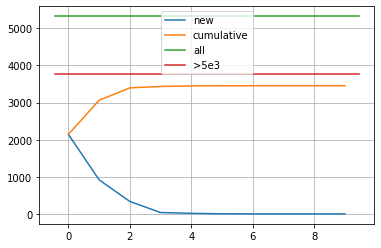

In [69]:
ceiling = len(list(filter(lambda x: x.height >=5e3,boxes)))

counts = [len(b) for b in b2s]
plt.plot(range(10),counts,label = 'new')
plt.plot(range(10),np.cumsum(counts),label = 'cumulative')
xl = plt.xlim()
plt.plot(xl,[len(boxes),len(boxes)],label = 'all')
plt.plot(xl,[ceiling,ceiling],label = '>5e3')
plt.legend()
plt.grid()